# CNN Model for Stock Price Prediction

This document outlines the implementation of a Convolutional Neural Network (CNN) model for predicting stock prices using historical price data. Unlike traditional recurrent neural networks, this CNN model utilizes convolutional layers to process time series data, capturing temporal dependencies through the use of filters and pooling, which allows it to detect local patterns effectively within the data.

## Model Architecture

The CNN model implemented in PyTorch includes key components designed to optimize the accuracy of stock price predictions:

- **Convolutional Layers**: Employed to extract high-level features from the input data by sliding filters over the time series. This method helps in identifying significant patterns without the need for maintaining hidden states.
- **Input Layer**: Accepts sequences of historical stock prices, reshaping them into a format amenable to convolutional operations.
- **Output Layer**: Features a linear layer that takes the output from the convolutional layers and projects it onto the predicted future stock price.
- **Dropout and Activation**: Dropout is used for regularization, and ReLU activation functions are applied to introduce non-linearity and help the network learn complex patterns.
- **Loss Function and Optimizer**: Utilizes Mean Squared Error (MSE) for its loss function to quantify the prediction accuracy, and the Adam optimizer to adjust the weights based on computed gradients.

## Forecasting Process

The process of forecasting with the CNN model involves several crucial steps:

1. **Data Preparation**: The stock data is first adjusted to a suitable scale using techniques like MinMax or Standard Scaling to facilitate effective learning.
2. **Model Initialization**: Define parameters such as the number of convolutional layers, number of filters, kernel size, and learning rate to configure the model.
3. **Training Loop**: During training, the model repeatedly processes batches of data, calculates loss, and optimizes the weights to reduce prediction errors over multiple epochs.
4. **Evaluation**: Post-training, the model's effectiveness is assessed using a separate test dataset to ensure it generalizes well to new, unseen data.
5. **Visualization**: The predicted and actual stock prices are graphically represented using libraries such as Matplotlib or Plotly to evaluate the model's predictive performance visually.

## Multiple Simulations

To test the robustness of the CNN model, multiple simulations are conducted:

1. **Repeatability**: Each simulation involves initializing and training the model from scratch, ensuring varied learning dynamics and providing insights into its stability under different conditions.
2. **Performance Analysis**: The variation in outcomes across different runs highlights the model’s reliability and assists in identifying any potential improvements.

## Usage Instructions

To deploy the CNN model for your stock price forecasting needs, follow these guidelines:

1. **Load Data**: Import your dataset containing historical stock price data.
2. **Set Model Parameters**: Customize settings such as filter sizes, number of layers, and learning rate according to your specific needs.
3. **Prepare Data**: Normalize the data and format it into suitable input shapes for convolutional processing.
4. **Instantiate and Train the Model**: Create an instance of the CNN model and commence the training using the prepared data.
5. **Evaluate and Visualize**: Post-training, evaluate the model's accuracy on test data and utilize visualization tools to draw comparisons between predicted and actual stock prices.

## Requirements

- Python 3.x
- PyTorch
- NumPy
- Matplotlib or Plotly

This CNN model provides a novel and effective approach for financial analysts and data scientists looking to leverage the power of convolutional neural networks for stock price forecasting. By capturing local and temporal patterns in stock data, it helps deliver precise predictions essential for informed trading and investment decisions.

In [7]:
# !pip install yfinance tensorflow keras numpy matplotlib seaborn tqdm scikit-learn graphviz

In [2]:
from utils import *
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from datetime import datetime
from datetime import timedelta
from tqdm import tqdm
import plotly.graph_objects as go


# Configure Modeling Parameters and Fetch Data

Enter a ticker and date range you would like to build the model on.  This model takes a a single ticker's data.  Also enter a training size for the proportion of the data you want to include in your training set vs. your test set.

In [3]:
# stock configs
ticker = ['TSLA']
start_date = '2014-04-01'
end_date = '2024-04-05'

# model configs
train_size = 0.8

In [4]:
# Data Fetching
data = fetch_stock_data(ticker, start_date, end_date)[ticker[0]]
data.reset_index(drop=False, inplace=True)
data['Date'] = pd.to_datetime(data['Date']).dt.tz_localize(None)

print(data.shape)
included_days = len(data)
data.head()

(2520, 8)


,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits
0,2014-04-01,13.934667,14.544000,13.905333,14.464667,110571000,0.0,0.0
1,2014-04-02,14.666667,15.392667,14.536667,15.352667,161734500,0.0,0.0
2,2014-04-03,15.353333,15.715333,14.800000,15.026667,163855500,0.0,0.0
3,2014-04-04,15.067333,15.218000,14.083333,14.148667,170184000,0.0,0.0
4,2014-04-07,13.720667,14.413333,13.567333,13.834667,147832500,0.0,0.0


# Model Implementation

Below we implement the model, first we separate the data into a train-test split.  For this LSTM model, we will leverage continuous windows of time for training and test data.


In [5]:
scaler = MinMaxScaler()
minmax = scaler.fit(data.iloc[:, 4:5].astype('float32')) # Close index
df_log = minmax.transform(data.iloc[:, 4:5].astype('float32')) # Close index
df_log = pd.DataFrame(df_log)
df_log.head()

,0
0,0.012205
1,0.014423
2,0.013608
3,0.011415
4,0.010631


In [6]:
simulation_size = 5
lookback = 30
train_len = int(included_days * train_size)
test_len = included_days - train_len

df_train = df_log.iloc[:train_len]
df_test = df_log.iloc[train_len:]


def create_dataset(X, look_back=1):
    dataX, dataY = [], []
    for i in range(len(X)-look_back):
        a = X[i:(i+look_back), 0]
        dataX.append(a)
        dataY.append(X[i + look_back, 0])
    return np.array(dataX), np.array(dataY)

lookback = 30  # this variable was previously defined but not used in your example
X_train, y_train = create_dataset(df_train.values, lookback)
X_test, y_test = create_dataset(df_test.values, lookback)

# Adjust for LSTM input shape
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim

class Model(nn.Module):
    def __init__(self, learning_rate, num_layers, size, size_layer, output_size, forget_bias=0.1):
        super(Model, self).__init__()
        self.num_layers = num_layers
        self.size_layer = size_layer
        self.output_size = output_size
        self.dropout = nn.Dropout(p=forget_bias)

        # Define convolutional layers for forward and backward sequences
        self.conv_forward = nn.Conv1d(in_channels=size, out_channels=size_layer, kernel_size=3, padding=1)
        self.conv_backward = nn.Conv1d(in_channels=size, out_channels=size_layer, kernel_size=3, padding=1)
        
        # Linear layer to process the concatenated outputs
        self.linear = nn.Linear(2 * size_layer, output_size)
        
        self.loss_fn = nn.MSELoss()
        self.optimizer = optim.Adam(self.parameters(), lr=learning_rate)

    def forward(self, x_forward, x_backward):
        # Apply convolution and activation function (ReLU) along with dropout
        x_forward = self.dropout(torch.relu(self.conv_forward(x_forward.transpose(1,2))))
        x_backward = self.dropout(torch.relu(self.conv_backward(x_backward.transpose(1,2))))
        
        # Get the last output for processing
        outputs_forward = x_forward[:, :, -1]
        outputs_backward = x_backward[:, :, -1]
        
        # Concatenate forward and backward outputs
        concatenated_outputs = torch.cat((outputs_forward, outputs_backward), dim=1)
        
        # Pass through linear layer
        out = self.linear(concatenated_outputs)
        return out
    
def calculate_accuracy(real, predict):
    real = torch.tensor(real) + 1
    predict = torch.tensor(predict) + 1
    percentage = 1 - torch.sqrt(torch.mean(torch.pow((real - predict) / real)))
    return percentage.item() * 100

In [7]:
def anchor(signal, weight):
    buffer = []
    last = signal[0]
    for i in signal:
        smoothed_val = last * weight + (1 - weight) * i
        buffer.append(smoothed_val)
        last = smoothed_val
    return buffer

In [8]:
num_layers = 1
size_layer = 128
timestamp = 5
epoch = 20
dropout_rate = 0.8
future_day = 60
learning_rate = 0.01

In [9]:
def forecast(model, X_train, y_train, X_test, epochs=20):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    model.train()

    X_train_tensor = torch.tensor(X_train, dtype=torch.float32).to(device)
    y_train_tensor = torch.tensor(y_train, dtype=torch.float32).unsqueeze(-1).to(device)

    for epoch in range(epochs):
        model.optimizer.zero_grad()
        outputs = model(X_train_tensor, X_train_tensor)  # Assuming same input for simplicity
        loss = model.loss_fn(outputs, y_train_tensor)
        loss.backward()
        model.optimizer.step()
        if epoch % 5 == 0:
            print(f'Epoch {epoch} Loss {loss.item()}')

    # Evaluation
    model.eval()
    X_test_tensor = torch.tensor(X_test, dtype=torch.float32).to(device)
    with torch.no_grad():
        test_pred = model(X_test_tensor, X_test_tensor)  # Assuming same input for simplicity

    return test_pred.squeeze().cpu().numpy()

In [10]:
def run_model_iterations(n_iterations, X_train, y_train, X_test):
    predictions = []
    for _ in range(n_iterations):
        # Initialize the model
        model = Model(learning_rate=0.01, num_layers=1, size=1, size_layer=128, output_size=1, forget_bias=0.1)
        
        # Train and predict
        preds = forecast(model, X_train, y_train, X_test)
        arr = scaler.inverse_transform(preds.reshape(-1, 1)).tolist()
        arr = [p[0] if isinstance(p, list) else p for p in arr]
        predictions.append(arr)
    
    return predictions

In [11]:
# Run the model multiple times
from datetime import datetime, timedelta 
n_iterations = 5
test_start_date = datetime.strptime(end_date, "%Y-%m-%d") - timedelta(days=test_len - 1)
model_predictions = run_model_iterations(n_iterations, X_train, y_train, X_test)
actual_data = y_test.flatten()
dates = pd.date_range(start=test_start_date, periods=len(y_test), freq='D')


Epoch 0 Loss 0.12908494472503662
Epoch 5 Loss 0.026204939931631088
Epoch 10 Loss 0.02823309414088726
Epoch 15 Loss 0.006572182290256023
Epoch 0 Loss 0.07276563346385956
Epoch 5 Loss 0.03199801966547966
Epoch 10 Loss 0.015006325207650661
Epoch 15 Loss 0.007283578161150217
Epoch 0 Loss 0.19914588332176208
Epoch 5 Loss 0.004487438593059778
Epoch 10 Loss 0.012408235110342503
Epoch 15 Loss 0.008004646748304367
Epoch 0 Loss 0.16960394382476807
Epoch 5 Loss 0.022008072584867477
Epoch 10 Loss 0.034041885286569595
Epoch 15 Loss 0.007991484366357327
Epoch 0 Loss 0.06577778607606888
Epoch 5 Loss 0.020129285752773285
Epoch 10 Loss 0.0028793844394385815
Epoch 15 Loss 0.007207656744867563


In [18]:
model_predictions = [[0] * 30 + pred for pred in model_predictions]
print(model_predictions[0])

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 223.39984130859375, 219.45497131347656, 221.6372528076172, 216.1071319580078, 211.002197265625, 202.9434356689453, 200.49468994140625, 193.4257354736328, 194.49685668945312, 205.76055908203125, 219.669677734375, 224.47344970703125, 221.17994689941406, 225.56532287597656, 216.30307006835938, 211.35105895996094, 212.77020263671875, 214.5264129638672, 214.2508544921875, 209.65855407714844, 198.82188415527344, 196.89857482910156, 204.57850646972656, 197.6715545654297, 194.04388427734375, 205.5862274169922, 210.92367553710938, 210.10780334472656, 215.44825744628906, 218.1336669921875, 211.40869140625, 205.6222381591797, 202.29022216796875, 202.5834197998047, 206.47268676757812, 207.45870971679688, 213.85858154296875, 220.89111328125, 214.00331115722656, 208.5394287109375, 210.27198791503906, 212.10464477539062, 213.40525817871094, 214.1710205078125, 216.95196533203125, 219.44943237304688, 233.18577575

In [19]:

# Creating traces for the actual and predicted stock prices
trace_actual = go.Scatter(
    x=dates,
    y=data['Close'].iloc[train_len:].values,
    mode='lines',
    name='Actual Price',
    line=dict(color='blue', width=2)
)

traces_predicted = []
for i, preds in enumerate(model_predictions):
    trace_predicted = go.Scatter(
        x=dates,
        y=preds,
        mode='lines',
        name=f'Predicted Price (Iteration {i+1})',
        line=dict(color=f'rgba(255, 0, 0, {1 - i*0.12})', dash='dot', width=2)  # Adjust opacity for clarity
    )
    traces_predicted.append(trace_predicted)

# Create the layout and figure
layout = go.Layout(
    title='Stock Price Prediction (During Test Period)',
    xaxis=dict(title='Date'),
    yaxis=dict(title='Price'),
    template='plotly_dark'
)

fig = go.Figure(data=[trace_actual] + traces_predicted, layout=layout)
fig.show()

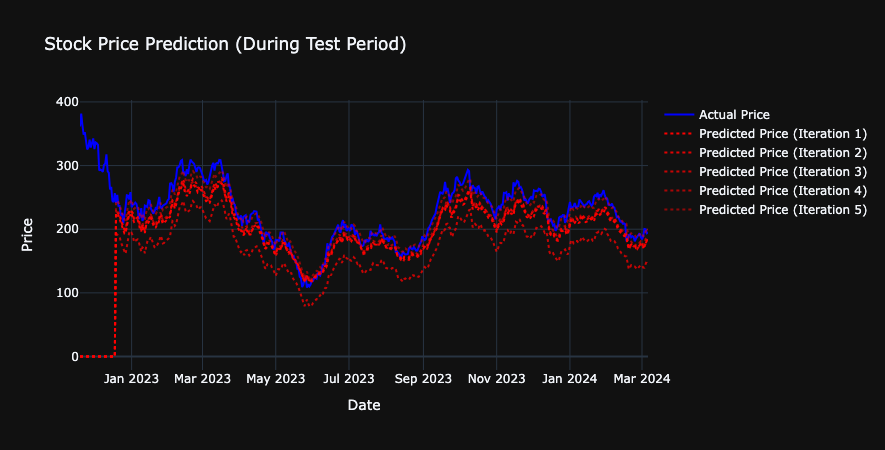